# Assignment 2

### Imports and reading dataset

In [1]:
import pandas as pd
import numpy as np
import gzip
import random
from collections import defaultdict


%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import seaborn as sns
from sklearn.preprocessing import OneHotEncoder 
from sklearn.linear_model import LogisticRegression
from sklearn import svm

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

In [2]:
def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

In [3]:
data = []

for d in readGz('modcloth_final_data.json.gz'):
    data.append(d)

In [48]:
random.seed(1)
random.shuffle(data)

train_data = data[:int(0.65*len(data))]
val_data = data[int(0.65*len(data)):int(0.85*len(data))]
test_data = data[int(0.85*len(data)):]

len(train_data), len(val_data), len(test_data)

(53813, 16558, 12419)

In [49]:
modcloth = pd.read_json('modcloth_final_data.json', lines=True)
modcloth.head()

,bra size,bust,category,cup size,fit,height,hips,item_id,length,quality,review_summary,review_text,shoe size,shoe width,size,user_id,user_name,waist
0,34.0,36,new,d,small,5ft 6in,38.0,123373,just right,5.0,NaN,NaN,NaN,NaN,7,991571,Emily,29.0
1,36.0,NaN,new,b,small,5ft 2in,30.0,123373,just right,3.0,NaN,NaN,NaN,NaN,13,587883,sydneybraden2001,31.0
2,32.0,NaN,new,b,small,5ft 7in,NaN,123373,slightly long,2.0,NaN,NaN,9.0,NaN,7,395665,Ugggh,30.0
3,NaN,NaN,new,dd/e,fit,NaN,NaN,123373,just right,5.0,NaN,NaN,NaN,NaN,21,875643,alexmeyer626,NaN
4,36.0,NaN,new,b,small,5ft 2in,NaN,123373,slightly long,5.0,NaN,NaN,NaN,NaN,18,944840,dberrones1,NaN


### EDA
1. Describe the dataset,
including its basic statistics and properties, and report any interesting findings. This exploratory analysis
should motivate the design of your model in the following sections. 

In [50]:
print('Number of entries: ',len(modcloth))
print('Unique users: ',modcloth['user_id'].nunique())
print('Unique items: ',modcloth['item_id'].nunique())

Number of entries:  82790
Unique users:  47958
Unique items:  1378


In [51]:
for i in modcloth.columns:
    print('Number of null values in ', i,': ', len(modcloth[modcloth[i].isna()]))

Number of null values in  bra size :  6018
Number of null values in  bust :  70936
Number of null values in  category :  0
Number of null values in  cup size :  6255
Number of null values in  fit :  0
Number of null values in  height :  1107
Number of null values in  hips :  26726
Number of null values in  item_id :  0
Number of null values in  length :  35
Number of null values in  quality :  68
Number of null values in  review_summary :  6725
Number of null values in  review_text :  6725
Number of null values in  shoe size :  54875
Number of null values in  shoe width :  64183
Number of null values in  size :  0
Number of null values in  user_id :  0
Number of null values in  user_name :  0
Number of null values in  waist :  79908


In [52]:
print("Bra size - Mean: ",modcloth['bra size'].mean(),"||| Median ", modcloth['bra size'].median())
print("Hips - Mean: ",modcloth['hips'].mean(),"||| Median ", modcloth['hips'].median())
print("Quality - Mean: ",modcloth['quality'].mean(),"||| Median ", modcloth['quality'].median())
print("Shoe size - Mean: ",modcloth['shoe size'].mean(),"||| Median ", modcloth['shoe size'].median())
print("Size - Mean: ",modcloth['size'].mean(),"||| Median ", modcloth['size'].median())

Bra size - Mean:  35.972125253998854 ||| Median  36.0
Hips - Mean:  40.358500998858446 ||| Median  39.0
Quality - Mean:  3.9490582916273786 ||| Median  4.0
Shoe size - Mean:  8.145817660755865 ||| Median  8.0
Size - Mean:  12.661601642710473 ||| Median  12.0


In [53]:
modcloth.describe()

,bra size,hips,item_id,quality,shoe size,size,user_id,waist
count,76772.000000,56064.000000,82790.000000,82722.000000,27915.000000,82790.000000,82790.000000,2882.000000
mean,35.972125,40.358501,469325.229170,3.949058,8.145818,12.661602,498849.564718,31.319223
std,3.224907,5.827166,213999.803314,0.992783,1.336109,8.271952,286356.969459,5.302849
min,28.000000,30.000000,123373.000000,1.000000,5.000000,0.000000,6.000000,20.000000
25%,34.000000,36.000000,314980.000000,3.000000,7.000000,8.000000,252897.750000,28.000000
50%,36.000000,39.000000,454030.000000,4.000000,8.000000,12.000000,497913.500000,30.000000
75%,38.000000,43.000000,658440.000000,5.000000,9.000000,15.000000,744745.250000,34.000000
max,48.000000,60.000000,807722.000000,5.000000,38.000000,38.000000,999972.000000,50.000000


539980    2008
668696    1555
397005    1506
175771    1438
407134    1437
Name: item_id, dtype: int64

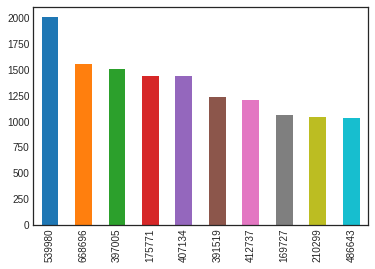

In [54]:
display(modcloth['item_id'].value_counts().head())
modcloth['item_id'].value_counts()[:10].plot(kind = 'bar')

In [55]:
text_sum = modcloth['review_summary'].fillna('').apply(len)
text_rev = modcloth['review_text'].fillna('').apply(len)
print("Review Summary - Mean: ",text_sum.mean(),"||| Median ", text_sum.median(), "||| Max ", max(text_sum))
print('Empty summaries ', len(text_sum[text_sum == 0]))
print("Review Text - Mean: ",text_rev.mean(),"||| Median ", text_rev.median(), "||| Max ", max(text_rev))
print('Empty reviews ', len(text_rev[text_rev == 0]))

Review Summary - Mean:  22.029001087087813 ||| Median  25.0 ||| Max  60
Empty summaries  6725
Review Text - Mean:  194.50846720618432 ||| Median  142.0 ||| Max  2262
Empty reviews  6725


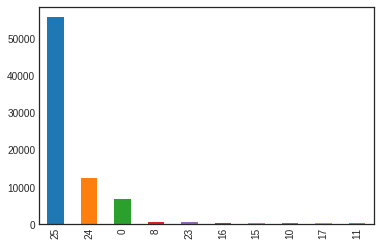

In [116]:
text_sum.value_counts()[:10].plot(kind = 'bar')

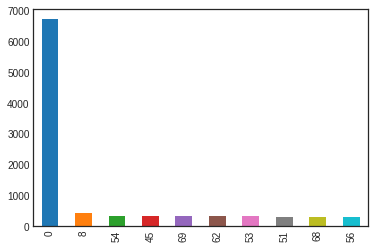

In [57]:
text_rev.value_counts()[:10].plot(kind = 'bar')

In [58]:
a = modcloth['height'].str.split()
for row in a[a.isna()].index:
    a.at[row] = ['0ft', '0in']

In [59]:
func = lambda x: print((int(x[0].strip('ft'))*12) + int(x[1].strip('in')))
def func(x):
    try:
        val = (int(x[0].strip('ft'))*12) + int(x[1].strip('in'))
    except:
        if 'ft' in x[0]:
            val = int(x[0].strip('ft'))*12
        else:
            val = int(x[0].strip('in'))
    return val
heights = a.apply(func)
modcloth['heights_conv'] = heights
a.apply(func).head()

0    66
1    62
2    67
3     0
4    62
Name: height, dtype: int64

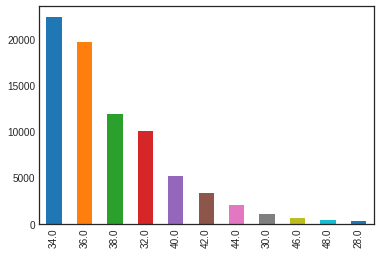

In [60]:
modcloth['bra size'].value_counts().plot(kind = 'bar')

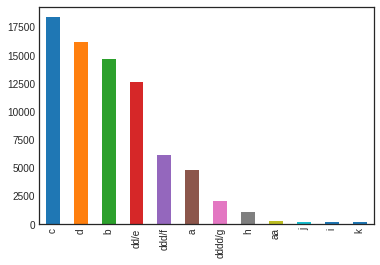

In [61]:
modcloth['cup size'].value_counts().plot(kind = 'bar')

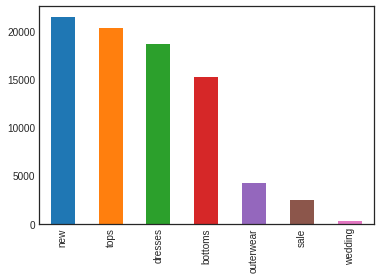

In [62]:
modcloth['category'].value_counts().plot(kind = 'bar')

fit      0.685554
large    0.157736
small    0.156710
Name: fit, dtype: float64

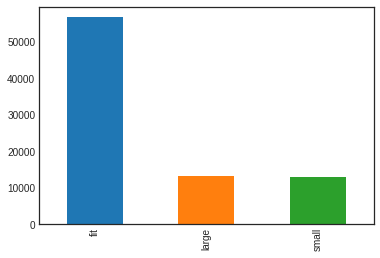

In [63]:
modcloth['fit'].value_counts().plot(kind = 'bar')
modcloth['fit'].value_counts()/len(modcloth)

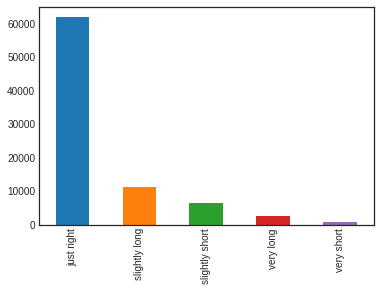

In [64]:
modcloth['length'].value_counts().plot(kind = 'bar')

5.0    29604
4.0    27118
3.0    19526
2.0     5130
1.0     1344
Name: quality, dtype: int64

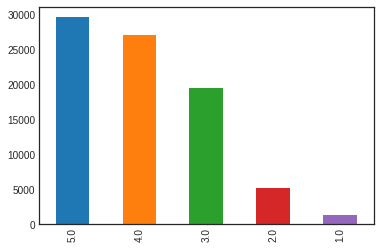

In [65]:
display(modcloth['quality'].value_counts())
modcloth['quality'].value_counts().plot(kind = 'bar')

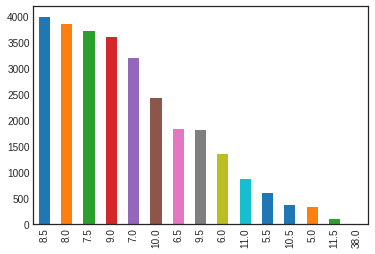

In [66]:
modcloth['shoe size'].value_counts().plot(kind = 'bar')

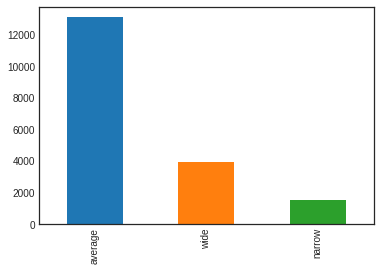

In [67]:
modcloth['shoe width'].value_counts().plot(kind = 'bar')

In [68]:
modcloth = modcloth.dropna(subset=['fit', 'quality']).reset_index(drop=True)

In [69]:
fit = modcloth['fit']
cats = []
for i in fit:
    if i == 'fit':
        cats.append(1)
    elif i == 'large' :
        cats.append(2)
    elif i == 'small':    
        cats.append(3)

cats_ser  = pd.Series(cats)
modcloth['cats'] = cats_ser

In [119]:
onehotencoder = OneHotEncoder() 
data2 = onehotencoder.fit_transform(modcloth[['fit']].dropna()).toarray() 

In [122]:
pd.DataFrame(data2).head()

,0,1,2
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,1.0,0.0,0.0
4,0.0,0.0,1.0


In [28]:
len(modcloth[modcloth['height'].isna()])

999

In [29]:
modcloth['review_text'][1]

"From the other reviews it seems like this dress either works for your body type or it doesn't. I have a small waist but flabby tummy and this dress is perfect for me! The detail around the front hides everything and the clingyness of the dress makes me look curvier than usual. The material is thick but clings to your bum (enough that when you walk the bum jiggle shows through!) and the slit is a bit high so it's not necessarily office appropriate without tights, but it's a good dress with tights or for an occasion."

### Task
2. Identify a predictive task that can be studied on this dataset. Describe how you will evaluate your
model at this predictive task, what relevant baselines can be used for comparison, and how you will assess
the validity of your model’s predictions. It’s fine to use models that were described in class here (i.e.,
you don’t have to invent anything new (though you may!)), though you should explain and justify which
model was appropriate for the task. It’s also important in this section to carefully describe what features
you will use and how you had to process the data to obtain them.


In [70]:
modcloth.head()

,bra size,bust,category,cup size,fit,height,hips,item_id,length,quality,review_summary,review_text,shoe size,shoe width,size,user_id,user_name,waist,heights_conv,cats
0,34.0,36,new,d,small,5ft 6in,38.0,123373,just right,5.0,NaN,NaN,NaN,NaN,7,991571,Emily,29.0,66,3
1,36.0,NaN,new,b,small,5ft 2in,30.0,123373,just right,3.0,NaN,NaN,NaN,NaN,13,587883,sydneybraden2001,31.0,62,3
2,32.0,NaN,new,b,small,5ft 7in,NaN,123373,slightly long,2.0,NaN,NaN,9.0,NaN,7,395665,Ugggh,30.0,67,3
3,NaN,NaN,new,dd/e,fit,NaN,NaN,123373,just right,5.0,NaN,NaN,NaN,NaN,21,875643,alexmeyer626,NaN,0,1
4,36.0,NaN,new,b,small,5ft 2in,NaN,123373,slightly long,5.0,NaN,NaN,NaN,NaN,18,944840,dberrones1,NaN,62,3


In [71]:
modcloth_shuffled = modcloth.sample(frac=1).reset_index(drop=True)
modcloth_shuffled.head()

,bra size,bust,category,cup size,fit,height,hips,item_id,length,quality,review_summary,review_text,shoe size,shoe width,size,user_id,user_name,waist,heights_conv,cats
0,36.0,42,new,dd/e,fit,5ft 1in,40.0,659701,just right,5.0,Perfect for someone who h,Perfect for someone who has a large bust and ...,6.5,average,15,120075,brittanynicolebrisson,NaN,61,1
1,36.0,39,dresses,d,large,5ft 7in,46.0,169727,just right,4.0,I ordered a size XL accor,I ordered a size XL according to my measuremen...,NaN,NaN,15,710709,nzudaire,NaN,67,2
2,36.0,NaN,new,b,large,5ft 4in,NaN,411494,slightly long,5.0,Not only is this top ador,"Not only is this top adorable, it's so comfort...",NaN,NaN,12,548289,anna.springerr,NaN,64,2
3,36.0,NaN,outerwear,c,fit,5ft 10in,42.0,781127,just right,4.0,Definitely not for chicks,Definitely not for chicks with long arms. It'...,NaN,NaN,12,910962,april.fischer,NaN,70,1
4,34.0,36,tops,b,large,5ft 6in,38.0,520945,slightly long,3.0,Great top for leggings...,Great top for leggings...I probably should hav...,7.0,narrow,8,42735,Katherine,NaN,66,2


In [72]:
all_users = set()
all_items = set()
all_bought = set()
usersPerItem = defaultdict(set)
itemsPerUser = defaultdict(set)

In [73]:
for i in range(len(modcloth)):
    users = modcloth['user_id'].values[i]
    items = modcloth['item_id'].values[i]
    itemsPerUser[users].add(items)
    usersPerItem[items].add(users)
    all_users.add(users)
    all_items.add(items)
    

In [74]:
len(pd.Series(usersPerItem)[pd.Series(usersPerItem).apply(len) == 1])

318

In [75]:
len(pd.Series(itemsPerUser)[pd.Series(itemsPerUser).apply(len) == 1])

31987

In [76]:
#Might want to predict the length of the clothes on the user so that it is just right
modcloth.length.value_counts()

just right        61908
slightly long     11247
slightly short     6316
very long          2426
very short          800
Name: length, dtype: int64

In [ ]:
train_data = data[:int(0.65*len(data))]
val_data = data[int(0.65*len(data)):int(0.85*len(data))]
test_data = data[int(0.85*len(data)):]

In [207]:
modcloth_shuffled['1'] = 1
print(len(modcloth_shuffled))
train = modcloth_shuffled[:int(0.65*len(modcloth_shuffled))]
valid = modcloth_shuffled[int(0.65*len(modcloth_shuffled)):int(0.85*len(modcloth_shuffled))]
test = modcloth_shuffled[int(0.85*len(modcloth_shuffled)):]
y_tr = train['cats']
X_tr = train[['1', 'quality', 'heights_conv', 'size']]
y_valid = valid['cats']
X_valid = valid[['1', 'quality', 'heights_conv', 'size']]
y_test = test['cats']
X_test = test[['1', 'quality', 'heights_conv', 'size']]
C = [.000000001, .00000001, .00001]
for c in C:
    clf = LogisticRegression(C = c,class_weight='balanced')
    clf.fit(X_tr, y_tr)
    print(clf.score(X_valid, y_valid))
    b  = clf.predict_proba(X_test)

    test_labels_auc2 = []    
    test_labels2 = []
    for r in test['fit']:
        label = [0, 0, 0]
        if 'small' in r:
            test_labels2.append(0)
            label[0] = 1
        elif 'fit' in r:
            test_labels2.append(1)
            label[1] = 1
        elif 'large' in r:
            test_labels2.append(2)
            label[2] = 1
        test_labels_auc2.append(label)
    test_labels_auc2 = np.array(test_labels_auc2)

    avg = []
    for i in range(3):
        avg.append(roc_auc_score(test_labels_auc2[:,i], b[:,i], average='weighted'))
    print(np.mean(avg))    

82722
0.6829666344294004
0.5122686190485722


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



0.6829666344294004
0.5104943315501231


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



0.6708776595744681
0.4576183105272804


In [105]:
from sklearn.metrics import balanced_accuracy_score

print(balanced_accuracy_score(y_tr, clf.predict(X_tr)))
print(balanced_accuracy_score(y_valid, clf.predict(X_valid)))
print(balanced_accuracy_score(y_test, clf.predict(X_test)))

0.38434689157094715
0.38441117445337564
0.3908152837658078


In [103]:
u = pd.Series(clf.predict(X_test))
u[u != 1].head()

162     2
594     2
1044    2
1425    2
1623    2
dtype: int64

In [81]:
clf.score(X_test, y_test)

0.6617777419614795

In [106]:
b  = clf.predict_proba(X_test)

test_labels_auc2 = []    
test_labels2 = []
for r in test['fit']:
    label = [0, 0, 0]
    if 'small' in r:
        test_labels2.append(0)
        label[0] = 1
    elif 'fit' in r:
        test_labels2.append(1)
        label[1] = 1
    elif 'large' in r:
        test_labels2.append(2)
        label[2] = 1
    test_labels_auc2.append(label)
test_labels_auc2 = np.array(test_labels_auc2)

avg = []
for i in range(3):
    avg.append(roc_auc_score(test_labels_auc2[:,i], b[:,i], average='weighted'))

In [107]:
clf.score(X_test, y_test)

0.6617777419614795

In [108]:
np.mean(avg)

0.41507326476155093

In [210]:
modcloth_shuffled['1'] = 1
print(len(modcloth_shuffled))
train = modcloth_shuffled[:int(0.65*len(modcloth_shuffled))]
valid = modcloth_shuffled[int(0.65*len(modcloth_shuffled)):int(0.85*len(modcloth_shuffled))]
test = modcloth_shuffled[int(0.85*len(modcloth_shuffled)):]
y_tr = train['cats']
X_tr = train[['1', 'user_id', 'item_id', 'size']]
y_valid = valid['cats']
X_valid = valid[['1', 'user_id', 'item_id', 'size']]
y_test = test['cats']
X_test = test[['1', 'user_id', 'item_id', 'size']]
C = [.00000001, .0001, .001, .01, .1, ]
for c in C:
    clf = LogisticRegression(C = c,class_weight='balanced')
    clf.fit(X_tr, y_tr)
    print(clf.score(X_valid, y_valid))
    b  = clf.predict_proba(X_test)

    test_labels_auc2 = []    
    test_labels2 = []
    for r in test['fit']:
        label = [0, 0, 0]
        if 'small' in r:
            test_labels2.append(0)
            label[0] = 1
        elif 'fit' in r:
            test_labels2.append(1)
            label[1] = 1
        elif 'large' in r:
            test_labels2.append(2)
            label[2] = 1
        test_labels_auc2.append(label)
    test_labels_auc2 = np.array(test_labels_auc2)

    avg = []
    for i in range(3):
        avg.append(roc_auc_score(test_labels_auc2[:,i], b[:,i], average='weighted'))
    print('AUC avg',np.mean(avg), 'with ', c)  

82722
0.6829666344294004


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



AUC avg 0.4932335481654139 with  1e-10


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



0.6817577369439072
AUC avg 0.48983460349407504 with  0.0001


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



0.6817577369439072
AUC avg 0.48983460349407504 with  0.001


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



0.6817577369439072
AUC avg 0.48983460349407504 with  0.01


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



0.6817577369439072
AUC avg 0.48983460349407504 with  0.1


In [110]:
from sklearn.metrics import balanced_accuracy_score

print(balanced_accuracy_score(y_tr, clf.predict(X_tr)))
print(balanced_accuracy_score(y_valid, clf.predict(X_valid)))
print(balanced_accuracy_score(y_test, clf.predict(X_test)))

0.3337846760273124
0.3337023750056966
0.3336268895038766


In [111]:
b  = clf.predict_proba(X_test)

test_labels_auc2 = []    
test_labels2 = []
for r in test['fit']:
    label = [0, 0, 0]
    if 'small' in r:
        test_labels2.append(0)
        label[0] = 1
    elif 'fit' in r:
        test_labels2.append(1)
        label[1] = 1
    elif 'large' in r:
        test_labels2.append(2)
        label[2] = 1
    test_labels_auc2.append(label)
test_labels_auc2 = np.array(test_labels_auc2)

avg = []
for i in range(3):
    avg.append(roc_auc_score(test_labels_auc2[:,i], b[:,i], average='weighted'))

In [112]:
np.mean(avg)

0.48983460349407504

In [143]:
modcloth_shuffled['1'] = 1
print(len(modcloth_shuffled))
train = modcloth_shuffled[:int(0.65*len(modcloth_shuffled))]
valid = modcloth_shuffled[int(0.65*len(modcloth_shuffled)):int(0.85*len(modcloth_shuffled))]
test = modcloth_shuffled[int(0.85*len(modcloth_shuffled)):]
y_tr = train['cats']
X_tr = train[['1', 'user_id', 'item_id', 'quality', 'heights_conv','size']]
y_valid = valid['cats']
X_valid = valid[['1', 'user_id', 'item_id', 'quality', 'heights_conv','size']]
y_test = test['cats']
X_test = test[['1', 'user_id', 'item_id', 'quality', 'heights_conv','size']]
C = [.00000001, .0001, .001, .01, .1, 1, 10]
for c in C:
    clf = LogisticRegression(C = c,class_weight='balanced')
    clf.fit(X_tr, y_tr)
    print(clf.score(X_valid, y_valid))
    b  = clf.predict_proba(X_test)

    test_labels_auc2 = []    
    test_labels2 = []
    for r in test['fit']:
        label = [0, 0, 0]
        if 'small' in r:
            test_labels2.append(0)
            label[0] = 1
        elif 'fit' in r:
            test_labels2.append(1)
            label[1] = 1
        elif 'large' in r:
            test_labels2.append(2)
            label[2] = 1
        test_labels_auc2.append(label)
    test_labels_auc2 = np.array(test_labels_auc2)

    avg = []
    for i in range(3):
        avg.append(roc_auc_score(test_labels_auc2[:,i], b[:,i], average='weighted'))
    print('AUC avg',np.mean(avg))

82722


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.6829666344294004
AUC avg 0.4931540163427715


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.676075918762089
AUC avg 0.4813931707246037


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.6758341392649904
AUC avg 0.4812539734352171


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.6758341392649904
AUC avg 0.4812399726010674


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.6758341392649904
AUC avg 0.48123842551605156


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.6758341392649904
AUC avg 0.4812384117884518


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.6758341392649904
AUC avg 0.4812383673591589


In [114]:
b  = clf.predict_proba(X_test)

test_labels_auc2 = []    
test_labels2 = []
for r in test['fit']:
    label = [0, 0, 0]
    if 'small' in r:
        test_labels2.append(0)
        label[0] = 1
    elif 'fit' in r:
        test_labels2.append(1)
        label[1] = 1
    elif 'large' in r:
        test_labels2.append(2)
        label[2] = 1
    test_labels_auc2.append(label)
test_labels_auc2 = np.array(test_labels_auc2)

avg = []
for i in range(3):
    avg.append(roc_auc_score(test_labels_auc2[:,i], b[:,i], average='weighted'))

In [117]:
clf.score(X_test, y_test)

0.6837779031348215

In [115]:
np.mean(avg)

0.4812384117884518

In [85]:
#model = svm.SVC(gamma='scale')
#model.fit(X_tr, y_tr)  

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [86]:
#print(model.score(X_tr, y_tr))
#print(model.score(X_valid, y_valid))
#print(model.score(X_test, y_test))

0.6852275474715914
0.6829666344294004
0.6916753968893545


In [87]:
#z = pd.Series(model.predict(X_test))
#z[z != 1]

Series([], dtype: int64)

### Model
3. Describe your model. Explain and justify your decision to use the model you proposed. How will you
optimize it? Did you run into any issues due to scalability, overfitting, etc.? What other models did you
consider for comparison? What were your unsuccessful attempts along the way? What are the strengths
and weaknesses of the different models being compared?

In [88]:
item_data = {}
item_index = {}
user_index = {}
user_data = {}
u_index = 0
i_index = 0
for r in train_data:
    if r['item_id'] + '|' + str(r['size']) not in item_data:
        item_data[r['item_id'] + '|' + str(r['size'])] = [r]
        item_index[r['item_id'] + '|' + str(r['size'])] = i_index
        i_index += 1
    else:
        item_data[r['item_id'] + '|' + str(r['size'])].append(r)
        
    if r['user_id'] not in user_data:
        user_data[r['user_id']] = [r]
        user_index[r['user_id']] = u_index
        u_index += 1
    else:
        user_data[r['user_id']].append(r)

In [89]:
item_data['657081|32']
item_index['657081|32']
user_index['639589']
user_data['639589']

KeyError: '639589'

In [90]:
len(pd.Series(user_data)[pd.Series(user_data).apply(len) == 1])

25651

In [91]:
len(pd.Series(item_data)[pd.Series(item_data).apply(len) == 1])

1751

In [92]:
true_size_item = np.zeros(len(item_data))
true_size_cust = np.zeros(len(user_data))
w = 1; b_1 = -1; b_2 = 1; lamda = 2

for item in item_data:
    true_size_item[item_index[item]] = int(item.split('|')[1])

In [93]:
len(user_data), len(user_index), len(item_data), len(item_index),len(true_size_item)

(35532, 35532, 4203, 4203, 4203)

In [205]:
def calc_auc():
    train_features = []
    train_labels = []
    for r in train_data:
        fe = []
        fe.append(true_size_cust[user_index[r['user_id']]])
        fe.append(true_size_item[item_index[r['item_id'] + '|' + str(r['size'])]])
        try:
            fe.append(r['quality'])
        except:
            fe.append(3.95)
        try:
            fe.append(func(r['height'].split()))
        except:
            fe.append(64.28)
        train_features.append(fe)

        if 'small' in r['fit']:
            train_labels.append(0)
        elif 'fit' in r['fit']:
            train_labels.append(1)
        elif 'large' in r['fit']:
            train_labels.append(2)

    c = 100
    clf_1LV = LogisticRegression(fit_intercept=True, multi_class='ovr', C=c)
    clf_1LV.fit(train_features, train_labels)

    test_features = []; test_labels = []; test_labels_auc = []
    for r in test_data:
        fe = []
        try:
            fe.append(true_size_cust[user_index[r['user_id']]])
        except KeyError:
            fe.append(np.mean(true_size_cust))
        try:
            fe.append(true_size_item[item_index[r['item_id'] + '|' + str(r['size'])]])
        except KeyError:
            fe.append(np.mean(true_size_item))
        try:
            fe.append(r['quality'])
        except:
            fe.append(3.95)
        try:
            fe.append(func(r['height'].split()))
        except:
            fe.append(64.28)    

        test_features.append(fe)
        label = [0, 0, 0]
        if 'small' in r['fit']:
            test_labels.append(0)
            label[0] = 1
        elif 'fit' in r['fit']:
            test_labels.append(1)
            label[1] = 1
        elif 'large' in r['fit']:
            test_labels.append(2)
            label[2] = 1
        test_labels_auc.append(label)

    test_labels_auc = np.array(test_labels_auc)

    pred = clf_1LV.predict_proba(test_features)
    AUC = []
    for i in range(3):
        AUC.append(roc_auc_score(test_labels_auc[:,i], pred[:,i], average='weighted'))
    print('Average AUC', np.mean(AUC), AUC)
    
def f(s,t):
    return w*(s-t)

def cal_loss_user(user, cust_size):
    loss = 0
    for r in user_data[user]:
        if 'small' in r['fit']:
            loss += max(0, 1 - f(cust_size, true_size_item[item_index[r['item_id'] + '|' + str(r['size'])]]) + b_2)
        elif 'fit' in r['fit']:
            loss += max(0, 1 + f(cust_size, true_size_item[item_index[r['item_id'] + '|' + str(r['size'])]]) - b_2)
            loss += max(0, 1 - f(cust_size, true_size_item[item_index[r['item_id'] + '|' + str(r['size'])]]) + b_1)
        elif 'large' in r['fit']:
            loss += max(0, 1 + f(cust_size, true_size_item[item_index[r['item_id'] + '|' + str(r['size'])]]) - b_1)
    return loss
            
def cal_loss_item(item, product_size):
    loss = 0
    for r in item_data[item]:
        if 'small' in r['fit']:
            loss += max(0, 1 - f(true_size_cust[user_index[r['user_id']]], product_size) + b_2)
        elif 'fit' in r['fit']:
            loss += max(0, 1 + f(true_size_cust[user_index[r['user_id']]], product_size) - b_2)
            loss += max(0, 1 - f(true_size_cust[user_index[r['user_id']]], product_size) + b_1)
        elif 'large' in r['fit']:
            loss += max(0, 1 + f(true_size_cust[user_index[r['user_id']]], product_size) - b_1)
    return loss

def total_loss():
    loss = 0
    for item in item_data:
        for r in item_data[item]:
            product_size = true_size_item[item_index[r['item_id'] + '|' + str(r['size'])]]
            if 'small' in r['fit']:
                loss += max(0, 1 - f(true_size_cust[user_index[r['user_id']]], product_size) + b_2)
            elif 'fit' in r['fit']:
                loss += max(0, 1 + f(true_size_cust[user_index[r['user_id']]], product_size) - b_2)
                loss += max(0, 1 - f(true_size_cust[user_index[r['user_id']]], product_size) + b_1)
            elif 'large' in r['fit']:
                loss += max(0, 1 + f(true_size_cust[user_index[r['user_id']]], product_size) - b_1)
    return loss

for iterr in range(0,220):
    
    ## Phase 1
    for user in user_data:
        candidate_sizes = []
        for r in user_data[user]:
            if 'small' in r['fit']:
                candidate_sizes.append(true_size_item[item_index[r['item_id'] + '|' + str(r['size'])]] + ((b_2+1)/w))
            elif 'fit' in r['fit']:
                candidate_sizes.append(true_size_item[item_index[r['item_id'] + '|' + str(r['size'])]] + ((b_1+1)/w))
                candidate_sizes.append(true_size_item[item_index[r['item_id'] + '|' + str(r['size'])]] + ((b_2-1)/w))
            elif 'large' in r['fit']:
                candidate_sizes.append(true_size_item[item_index[r['item_id'] + '|' + str(r['size'])]] + ((b_1-1)/w))

        flag = 0
        candidate_sizes = list(set(candidate_sizes))
        candidate_sizes = sorted(candidate_sizes)

        if len(candidate_sizes) == 1:
            true_size_cust[user_index[user]] = candidate_sizes[0]
        else:
            for s in range(1, len(candidate_sizes)):
                slope = (cal_loss_user(user, candidate_sizes[s]) - cal_loss_user(user, candidate_sizes[s-1]))/(candidate_sizes[s] - candidate_sizes[s-1])
                if slope>=0:
                    flag=1
                    true_size_cust[user_index[user]] = candidate_sizes[s-1]
                    break

            if flag==0:
                true_size_cust[user_index[user]] = candidate_sizes[-1]

    ## Phase 2
    for item in item_data:
        candidate_sizes = []
        for r in item_data[item]:
            if 'small' in r['fit']:
                candidate_sizes.append(true_size_cust[user_index[r['user_id']]] - ((b_2+1)/w))
            elif 'fit' in r['fit']:
                candidate_sizes.append(true_size_cust[user_index[r['user_id']]] - ((b_1+1)/w))
                candidate_sizes.append(true_size_cust[user_index[r['user_id']]] - ((b_2-1)/w))
            elif 'large' in r['fit']:
                candidate_sizes.append(true_size_cust[user_index[r['user_id']]] - ((b_1-1)/w))

        flag = 0
        candidate_sizes = list(set(candidate_sizes))
        candidate_sizes = sorted(candidate_sizes)
        if len(candidate_sizes) == 1:
            true_size_item[item_index[item]] = candidate_sizes[0]
        else:
            for s in range(1, len(candidate_sizes)):
                slope = (cal_loss_item(item, candidate_sizes[s]) - cal_loss_item(item, candidate_sizes[s-1]))/(candidate_sizes[s] - candidate_sizes[s-1])
                if slope>=0:
                    flag=1
                    true_size_item[item_index[item]] = candidate_sizes[s-1]
                    break

            if flag==0:
                true_size_item[item_index[item]] = candidate_sizes[-1]

    ## Phase 3
    learning_rate = 0.0000005/np.sqrt(iterr+1)
    grad_w = 0
    grad_b1 = 0
    grad_b2 = 0
    for r in train_data:
        s = true_size_cust[user_index[r['user_id']]]
        t = true_size_item[item_index[r['item_id'] + '|' + str(r['size'])]]

        if 'small' in r['fit']:
            A = 1 - f(s, t) + b_2
            if A>0:
                grad_w += -1*(s - t)
                grad_b2 += 1
        elif 'fit' in r['fit']:
            B = 1 + f(s, t) - b_2
            C = 1 - f(s, t) + b_1
            if B>0:
                grad_w += (s - t)
                grad_b2 += -1
            if C>0:
                grad_w += -1*(s - t)
                grad_b1 += 1
        elif 'large' in r['fit']:
            D = 1 + f(s, t) - b_1
            if D>0:
                grad_w += (s - t)
                grad_b1 += -1

    w -= learning_rate*(grad_w + 2*lamda*w)
    b_1 -= learning_rate*(grad_b1 + 2*lamda*b_1)
    b_2 -= learning_rate*(grad_b2 + 2*lamda*b_2)
    if iterr%5 == 0:
        print(iterr, total_loss())
        calc_auc()

0 19535.508616951854


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6293295446743786 [0.6285926199383326, 0.6244310289120757, 0.6349649851727275]
5 19185.266107668347


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6291529628958851 [0.6287735668105972, 0.6235962328843399, 0.6350890889927182]
10 19436.59432494836


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6307077104934321 [0.6302202948457543, 0.6257740584880463, 0.6361287781464957]
15 18751.038124960854


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6331869479615753 [0.6322758752283633, 0.6283667879230919, 0.6389181807332706]
20 18496.45855086232


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6326219314749567 [0.6329680767270537, 0.6274415301069951, 0.6374561875908215]
25 18317.74642615943


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6319104942508093 [0.6307367307702847, 0.6292630308451816, 0.6357317211369614]
30 18364.607358927093


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6333330112074343 [0.6344759839359831, 0.6288663414110269, 0.6366567082752929]
35 18511.725869869362


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6330844032554955 [0.6335417809416909, 0.6279772988201525, 0.6377341300046433]
40 18296.799556890415


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6329932023595024 [0.6337300264694584, 0.6286885450968033, 0.6365610355122454]
45 18199.165007110638


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6335674987595084 [0.6356423987616697, 0.630059460701294, 0.6350006368155612]
50 18101.338645059725


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6337257296558182 [0.6340625263112795, 0.6279869094317322, 0.6391277532244428]
55 17850.715766183956


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6348912948621727 [0.6362972849499731, 0.6281820048467992, 0.6401945947897456]
60 17637.48939840261


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6361741712761341 [0.6378603430916109, 0.6295166899711284, 0.6411454807656629]
65 17593.398349918854


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6355672109710894 [0.6364734989056998, 0.6255927535378492, 0.6446353804697191]
70 17653.153172684393


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6370619855703957 [0.636609607621291, 0.6294762186179208, 0.6451001304719756]
75 17515.0584977368


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.634689759442864 [0.634615679704108, 0.6260893170577372, 0.6433642815667469]
90 17046.718920562922


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6371612722539386 [0.6358487041025419, 0.6292936932726024, 0.6463414193866714]
95 16964.21077994383


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6379834981749305 [0.6380388736854323, 0.62978391073786, 0.6461277101014993]
100 16823.71713944999


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6376292118958179 [0.6388837989277703, 0.6328479262588452, 0.641155910500838]
105 16830.770704423627


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6365962580809755 [0.6370432175064107, 0.6301985552352358, 0.6425470015012802]
110 16690.741266004483


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.638125075622693 [0.6386739314444512, 0.6332114819654586, 0.6424898134581692]
115 16769.589909751827


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6388273599874922 [0.6404079973336243, 0.6312213073665796, 0.6448527752622728]
120 16607.792019171433


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6401329540478978 [0.6425277211903633, 0.6317760989886891, 0.6460950419646412]
125 16552.25979037467


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6384257090392234 [0.6415135817267573, 0.6298123154343065, 0.6439512299566064]
130 16977.045951448294


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6388576022789509 [0.6412105256078184, 0.6299640258028141, 0.6453982554262202]
135 16822.786593414603


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6391236119529397 [0.6424146792153721, 0.6289441263450661, 0.6460120302983807]
140 16738.38506667446


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6398675275190479 [0.6431616330853782, 0.6284087847702011, 0.6480321647015641]
145 16981.502526965716


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6383383178432277 [0.6411494709844815, 0.6283511211007232, 0.6455143614444782]
150 16781.428181193918


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6393339145176067 [0.6415796681876765, 0.6293646897587798, 0.6470573856063637]
155 16935.03729696729


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6379467539670668 [0.6395306391579593, 0.6301168040170526, 0.6441928187261884]
160 17051.792593209786


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6388396604367156 [0.6414273679155091, 0.6286570283927975, 0.6464345850018403]
165 16541.02253591554


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6394803575513289 [0.6423643359294626, 0.6300530231170295, 0.6460237136074949]
170 16456.700880590262


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.640239515178363 [0.6412848074873743, 0.6302341450079585, 0.6491995930397564]
175 16345.523991213593


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6426184300813692 [0.646331765492455, 0.6318843785458199, 0.6496391462058329]
180 16274.995280079946


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6432333541463765 [0.6467410631326228, 0.633012877914418, 0.6499461213920888]
185 16331.301280547921


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6410101673611702 [0.644412816937265, 0.6296601321626897, 0.6489575529835561]
190 16663.446074847958


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.640866512116831 [0.6436652403150827, 0.6305149274154747, 0.6484193686199354]
195 16377.635130856233


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6434111401504912 [0.6478733262289766, 0.6312660501027114, 0.6510940441197854]
200 16388.769353734555


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.643306814326752 [0.6490262397874871, 0.6311512109218042, 0.6497429922709645]
205 16340.698177192005


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6449698736002188 [0.6488366989351934, 0.6333220039986247, 0.6527509178668384]
210 16242.341261283851


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6448723153971154 [0.6503745729788328, 0.6324331902318354, 0.6518091829806779]
215 16231.422906236585


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Average AUC 0.6455846519278677 [0.6507454094446098, 0.6316332975045665, 0.654375248834427]


In [186]:
train_features = []; train_labels = []
for r in train_data:
    fe = []
    fe.append(true_size_cust[user_index[r['user_id']]])
    fe.append(true_size_item[item_index[r['item_id'] + '|' + str(r['size'])]])
    try:
        fe.append(r['quality'])
    except:
        fe.append(3.95)
    try:
        fe.append(func(r['height'].split()))
    except:
        fe.append(64.28)        
    train_features.append(fe)

    if 'small' in r['fit']:
        train_labels.append(0)
    elif 'fit' in r['fit']:
        train_labels.append(1)
    elif 'large' in r['fit']:
        train_labels.append(2)

c = 100
clf_1LV = LogisticRegression(fit_intercept=True, multi_class='ovr', C=c)
clf_1LV.fit(train_features, train_labels)

test_features = []; test_labels = []; test_labels_auc = []
for r in val_data:
    fe = []
    try:
        u = user_index[r['user_id']]
        fe.append(true_size_cust[u])
    except KeyError:
        fe.append(np.mean(true_size_cust))
    try:
        fe.append(true_size_item[item_index[r['item_id'] + '|' + str(r['size'])]])
    except KeyError:
        fe.append(np.mean(true_size_item))
    try:
        fe.append(r['quality'])
    except:
        fe.append(3.95)
    try:
        fe.append(func(r['height'].split()))
    except:
        fe.append(64.28)                     
    test_features.append(fe)
    label = [0, 0, 0]
    if 'small' in r['fit']:
        test_labels.append(0)
        label[0] = 1
    elif 'fit' in r['fit']:
        test_labels.append(1)
        label[1] = 1
    elif 'large' in r['fit']:
        test_labels.append(2)
        label[2] = 1
    test_labels_auc.append(label)

test_labels_auc = np.array(test_labels_auc)

pred = clf_1LV.predict_proba(test_features)
AUC = []
for i in range(3):
    AUC.append(roc_auc_score(test_labels_auc[:,i], pred[:,i], average='weighted'))
print('Average AUC', np.mean(AUC), AUC)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Average AUC 0.6232524604306696 [0.6264286048282443, 0.6090693898590719, 0.6342593866046927]


base

Average AUC 0.5954133904825681 [0.5958294030975526, 0.5577001999854292, 0.6327105683647226]

with quality

Average AUC 0.6230716920518676 [0.626021897635188, 0.6089814591630749, 0.6342117193573399]

with quality and height

Average AUC 0.6232507416825211 [0.6264257709166112, 0.6090664417576013, 0.634260012373351]

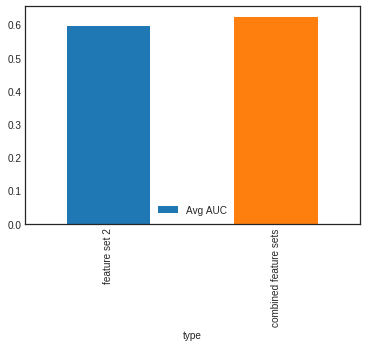

In [203]:
import plotly.express as px
l1 = ['feature set 2', 'combined feature sets']
l2 = [.595, .62325]
df1 = pd.DataFrame([l1,l2]).T
df1.columns = ['type', 'Avg AUC']
df1.plot(kind = 'bar', x = 'type', y = 'Avg AUC')
fig = px.bar(df1, x="type", y="Avg AUC", text ="Avg AUC", log_y=True )
fig.show()

Average AUC 0.611738770035572 [0.606508305281231, 0.5858649006243626, 0.6428431042011222]

### Literature
4. Describe literature related to the problem you are studying. If you are using an existing dataset, where
did it come from and how was it used? What other similar datasets have been studied in the past and
how? What are the state-of-the-art methods currently employed to study this type of data? Are the
conclusions from existing work similar to or different from your own findings?

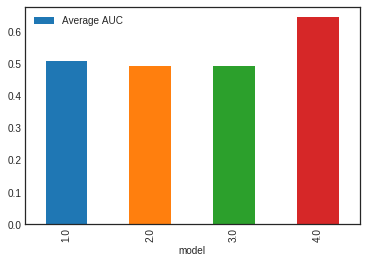

In [206]:
l1 = [1,2,3,4]
l2=[.5104,.4932,.4931,.6456]
ex = pd.DataFrame([l1,l2]).T
ex.columns = ['model', 'Average AUC']
ex.plot(kind = 'bar', x = 'model', y = 'Average AUC')

In [158]:
clf_1LV.score(test_features, test_labels)

0.6195192656117888

In [232]:
balanced_accuracy_score(test_labels, clf_1LV.predict(test_features))

0.41382913603459337

In [176]:
def func(x):
    try:
        val = (int(x[0].strip('ft'))*12) + int(x[1].strip('in'))
    except:
        if 'ft' in x[0]:
            val = int(x[0].strip('ft'))*12
        else:
            val = int(x[0].strip('in'))
    return val
func(train_data[0]['height'].split())
modcloth_shuffled['heights_conv'].mean()

64.27800343318584

### Result
5. Describe your results and conclusions. How well does your model perform compared to alternatives,
and what is the significance of the results? Which feature representations worked well and which do not?
What is the interpretation of your model’s parameters? Why did the proposed model succeed why others
failed (or if it failed, why did it fail)?